# 04e - Vertex AI > Notebooks - Forecasting with Prophet (Python)

In the prior notebooks of this `04` series we have git forecast models using Vertex AI AutoML and BigQuery ML ARIMA+.  In this notebook and open-source solution named [Prophet](https://github.com/facebook/prophet) is utlized for custom forecasting.  Prophet is built on [Stan](https://mc-stan.org/), a probabalistic programming language, and has been implemented in Python and R.  Prophet is built to be robust to outliers and missing data while also being customizable where you can add domain knowledge about the forecasting.  It also offers automated visualizations, including interactive plots using [Plotly](https://plotly.com/graphing-libraries/).

The Prophet based forecast and fit within this notebook and the results are saved back to BigQuery using [Pandas gbq](https://github.com/googleapis/python-bigquery-pandas) for further processing in BigQuery.  In the next notebook, `04f`, the code from this notebook gets added to a custom container and used in a Vertex AI Training job as a managed service.

### Prerequisites:
-  04 - Time Series Forecasting - Data Review in BigQuery

### Overview:
- Setup
- Time Series Data
    - Forecast Data From BigQuery to Dataframe
    - Prepate Data for Prophet
    - Review a Series Dataframe
- Create Forcast Model - Single Series
- Create Forecast Models - All Series ... In Parallel
    - Create a function to fit a series
    - Test the function on a single series
    - Setup Multiprocessing
    - Run all series in parallel
    - Review predictions for one of the series
- Store the Results back in BigQuery
    - Concatenate the prediction for each series
    - Load the dataframe to BigQuery using Pandas GBQ
    - Use BigQuery to Transform the Results: Combine with Source Data
- Results
    - Retrieve Test Data
    - Review Custom Metrics with SQL
    - Retrieve The Forecating Data
    - Visualize the Time Series with Forecast

### Resources:
- [Prophet Quick Start](https://facebook.github.io/prophet/docs/quick_start.html)

---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/04e_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/04e_console.png">

---
## Setup

add packages: only needed once for the environment

In [34]:
!pip install pystan==2.19.1.1 -U -q
!pip install prophet -U -q
!pip install pandas-gbq -U -q

inputs:

In [65]:
PROJECT_ID='statmike-demo3'
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04e'

packages:

In [66]:
from google.cloud import bigquery
from prophet import Prophet

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

clients:

In [67]:
bigquery = bigquery.Client()

## Time Series Data

### Forecast Data From BigQuery to Dataframe

In [68]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
source = bigquery.query(query = query).to_dataframe()
source.head()

,start_station_name,date,num_trips,splits
0,Central Park North & Adam Clayton Powell Blvd,2016-09-01,14,TRAIN
1,Central Park North & Adam Clayton Powell Blvd,2016-09-02,151,TRAIN
2,Central Park North & Adam Clayton Powell Blvd,2016-09-03,255,VALIDATE
3,Central Park North & Adam Clayton Powell Blvd,2016-09-04,328,VALIDATE
4,Central Park North & Adam Clayton Powell Blvd,2016-09-05,259,VALIDATE


### Prepare Data for Prophet
Prophet expects a dataframe for a single time series with columns `ds` for timestamp and `y` for the demand variable of the forecast.  This data has multiple series, one for each station identified in the column `start_station_name`.  Below is the code to create a list of station in `seriesNames` and a list of dataframes in `seriesFrames`.

In [69]:
seriesNames = source['start_station_name'].unique().tolist()

seriesFrames = []
for s in seriesNames:
    frame = source[(source['start_station_name']==s) & (source['splits']!='TEST')][['date','num_trips']].rename(columns={'date':'ds','num_trips':'y'})
    seriesFrames.append(frame)

### Review a Series Dataframe

In [70]:
seriesNames[5],seriesFrames[5]

('Central Park West & W 68 St',
               ds    y
 1373  2015-09-01   48
 1374  2015-09-02   75
 1375  2015-09-03   83
 1376  2015-09-04   74
 1377  2015-09-05  173
 ...          ...  ...
 1713  2016-09-12  160
 1714  2016-09-13  184
 1715  2016-09-14  121
 1716  2016-09-15  170
 1717  2016-09-16  154
 
 [345 rows x 2 columns])

---
## Create Forecast Model - Single Series

Fit with seasonality and holidays added:


In [71]:
p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
p.add_country_holidays(country_name='US')
p.fit(seriesFrames[5])

Initial log joint probability = -8.6422


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       572.414   8.67351e-05       103.472      0.4026      0.4026      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       572.885   9.56904e-05       87.6577           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       573.001   7.57216e-07       81.8707      0.3089           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       573.001   9.55551e-09       93.7388      0.2654      0.2654      378   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Which holidays were considered:

In [72]:
print(p.train_holiday_names)

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11    Independence Day (Observed)
dtype: object


Make dataframe for forecast by adding periods to the known date range of the training data.  If you only want the forecast horizone then use the option `include_history = False`.

In [74]:
future = p.make_future_dataframe(periods = 2*14)
future

,ds
0,2015-09-01
1,2015-09-02
2,2015-09-03
3,2015-09-04
4,2015-09-05
...,...
368,2016-10-10
369,2016-10-11
370,2016-10-12
371,2016-10-13


Generate the predictions for the forecast horizon.  Since we kept the default that include the training history dates, we also get fit information for each of these dates.

In [75]:
forecast = p.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-09-01,49.503112,44.523532,117.693039,49.503112,49.503112,0.0,0.0,0.0,0.0,...,-13.566668,-13.566668,-13.566668,38.668095,38.668095,38.668095,0.0,0.0,0.0,80.864521
1,2015-09-02,49.691390,52.971777,124.575608,49.691390,49.691390,0.0,0.0,0.0,0.0,...,-5.481987,-5.481987,-5.481987,39.943573,39.943573,39.943573,0.0,0.0,0.0,90.412959
2,2015-09-03,49.879667,53.683431,126.060969,49.879667,49.879667,0.0,0.0,0.0,0.0,...,-8.499162,-8.499162,-8.499162,41.173166,41.173166,41.173166,0.0,0.0,0.0,88.813654
3,2015-09-04,50.067945,49.811023,124.527841,50.067945,50.067945,0.0,0.0,0.0,0.0,...,-9.879913,-9.879913,-9.879913,42.334116,42.334116,42.334116,0.0,0.0,0.0,88.782131
4,2015-09-05,50.256223,80.386167,153.754121,50.256223,50.256223,0.0,0.0,0.0,0.0,...,15.726633,15.726633,15.726633,43.403875,43.403875,43.403875,0.0,0.0,0.0,115.646714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,2016-10-10,125.744405,170.911284,246.205475,125.744370,125.744442,0.0,0.0,0.0,0.0,...,-7.250947,-7.250947,-7.250947,43.102799,43.102799,43.102799,0.0,0.0,0.0,209.859846
369,2016-10-11,125.932643,127.877184,200.942906,125.932606,125.932684,0.0,0.0,0.0,0.0,...,-13.566668,-13.566668,-13.566668,45.080206,45.080206,45.080206,0.0,0.0,0.0,163.706164
370,2016-10-12,126.120881,135.010098,210.630337,126.120842,126.120926,0.0,0.0,0.0,0.0,...,-5.481987,-5.481987,-5.481987,47.058438,47.058438,47.058438,0.0,0.0,0.0,173.957316
371,2016-10-13,126.309120,135.976652,210.219373,126.309078,126.309167,0.0,0.0,0.0,0.0,...,-8.499162,-8.499162,-8.499162,48.993978,48.993978,48.993978,0.0,0.0,0.0,173.063918


Use the built in plotting capabilites of Prophet to review the time series with forecast:

Notice the `;`? Refer to this [GitHub issue](https://github.com/facebook/prophet/issues/503). 

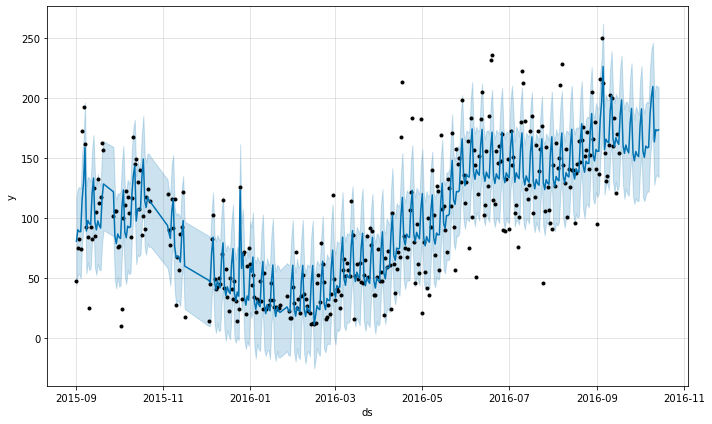

In [76]:
p.plot(forecast);

Visualize the forecast components to see the general trend, seasonalities, holidays:


Notice the `;`? Refer to this [GitHub issue](https://github.com/facebook/prophet/issues/503). 

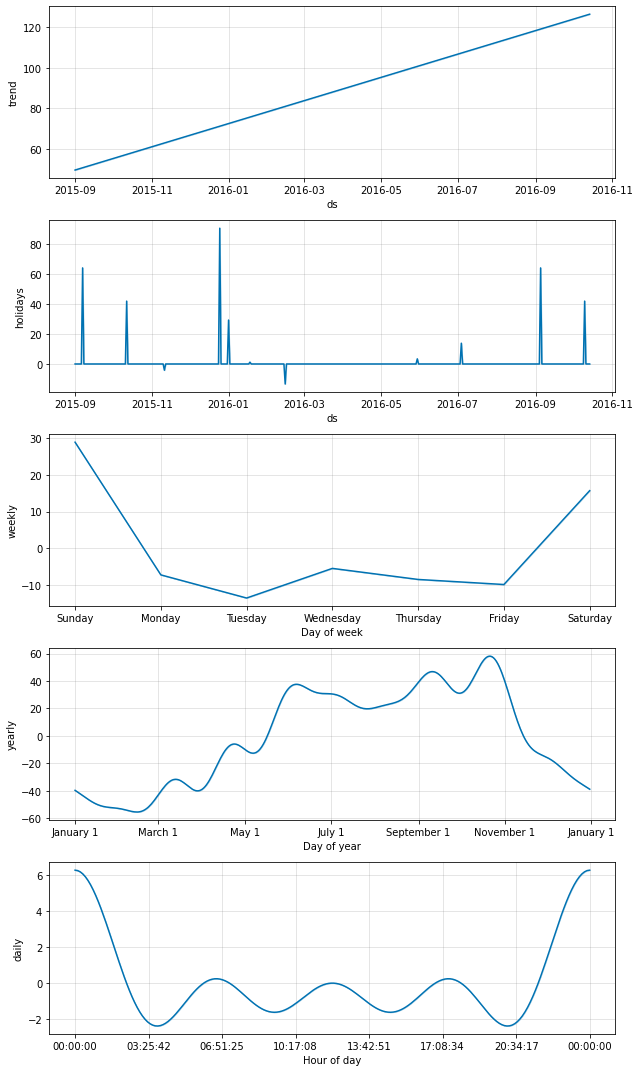

In [77]:
p.plot_components(forecast);

Visualize with plotly for interactive time series review:

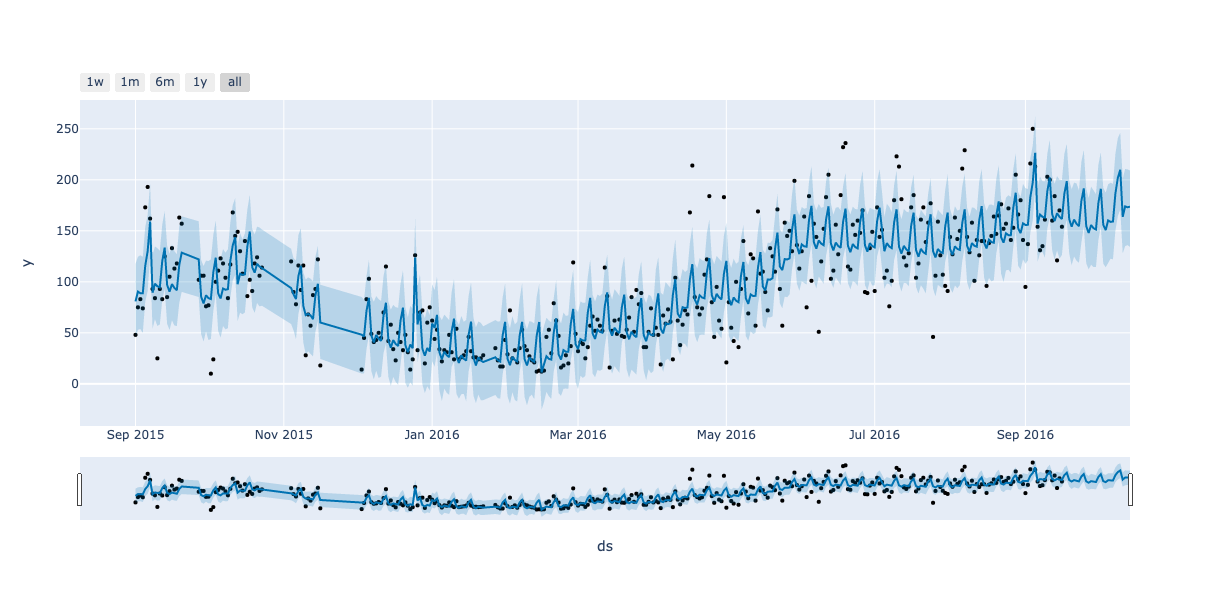

In [78]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(p, forecast)

---
## Create Forecast Model - All Series... In Parallel

Prophet does not have an input for indicating separate time series.  In order to fit all the time series and utilize available compute we will use the Python multiprocessing package.

### Create a function to fit a series

Return a dataframe for the entire series, including forecast horizon, that include the fitted forecast and confidence interval:

In [79]:
def run_prophet(series):
    p = Prophet(weekly_seasonality=True)
    p.add_country_holidays(country_name='US')
    p.fit(series)
    f = p.make_future_dataframe(periods = 2*14)
    f = p.predict(f)
    return f[['ds','yhat','yhat_lower','yhat_upper']]

### Test the function on a single series

In [80]:
test = run_prophet(seriesFrames[5])
test

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.6422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       505.205     0.0065443       151.124   7.846e-05       0.001      128  LS failed, Hessian reset 
      99       505.575   0.000227248       65.9679           1           1      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166        505.99    0.00484355       136.815   5.964e-05       0.001      259  LS failed, Hessian reset 
     199       506.239   1.82223e-05       67.9565           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       506.279   8.97527e-05       65.6909   1.149e-06       0.001      364  LS failed, Hessian reset 
     299        506.29   5.28925e-08         69.29           1           1      478   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

,ds,yhat,yhat_lower,yhat_upper
0,2015-09-01,94.195130,53.164621,134.176218
1,2015-09-02,102.109739,63.478983,145.326776
2,2015-09-03,98.598025,59.622212,142.262551
3,2015-09-04,96.978382,59.915772,137.279748
4,2015-09-05,121.601055,79.782539,161.158877
...,...,...,...,...
368,2016-10-10,257.766730,220.518080,298.853714
369,2016-10-11,179.985192,140.588395,221.563807
370,2016-10-12,188.997619,147.725786,228.540072
371,2016-10-13,186.583723,142.834620,227.345860


### Setup Multiprocessing

In [81]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

See how many cpu's are available to this notebook.  We chose `n1-standard-4` when setting up this notebook instance and expect to see 4 here:

In [82]:
cpu_count()

4

### Run all series in parallel

Three Things:
- Setup a pool that can use all the cpu's
- map the `run_prophet` function to each dataframe in the list `seriesFrames`
- Store the output from each series in a common list `predictions`

Bonus:
- Use the `tqdm` package to present a progress bar for the overall process of all series

In [83]:
pool = Pool(cpu_count())
predictions = list(tqdm(pool.imap(run_prophet, seriesFrames), total = len(seriesFrames)))
pool.close()
pool.join()

  0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.



Initial log joint probability = -52.3937
Iteration  1. Log joint probability =    3.62728. Improved by 56.0209.
Iteration  2. Log joint probability =    16.0592. Improved by 12.4319.
Iteration  3. Log joint probability =    25.0513. Improved by 8.99208.
Iteration  4. Log joint probability =    27.6277. Improved by 2.5764.
Iteration  5. Log joint probability =    27.6336. Improved by 0.00593232.

Initial log joint probability = -42.3717
Iteration  6. Log joint probability =    27.7252. Improved by 0.0916381.

Initial log joint probability = -45.5308
Iteration  7. Log joint probability =    27.7327. Improved by 0.00741522.
Iteration  8. Log joint probability =    27.7418. Improved by 0.00916085.
Iteration  1. Log joint probability =    25.7796. Improved by 68.1513.
Iteration  9. Log joint probability =    27.7509. Improved by 0.00907685.
Iteration 10. Log joint probability =    27.7513. Improved by 0.000376148.
Iteration  1. Log joint probability =     34.047. Improved by 79.5779.
Itera

  8%|▊         | 1/12 [00:04<00:52,  4.78s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -42.0782
Iteration  1. Log joint probability =    24.6959. Improved by 66.7741.
Iteration  2. Log joint probability =    48.7383. Improved by 24.0424.
Iteration  3. Log joint probability =     56.833. Improved by 8.09468.
Iteration  4. Log joint probability =    56.8414. Improved by 0.00844907.
Iteration  5. Log joint probability =    56.8895. Improved by 0.0480997.
Iteration  6. Log joint probability =    56.9565. Improved by 0.0669332.
Iteration  7. Log joint probability =    57.0742. Improved by 0.117716.
Iteration  8. Log joint probability =    57.0768. Improved by 0.00265851.
Iteration  9. Log joint probability =     57.138. Improved by 0.0612048.
Iteration 10. Log joint probability =    57.3573. Improved by 0.219233.
Iteration 11. Log joint probability =    57.6496. Improved by 0.292321.
Iteration 12. Log joint probability =    57.6788. Improved by 0.0291675.
Iteration 13. Log joint probability =    57.6917. Improved by 0.0129088.
Iteration 14. Lo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Iteration 35. Log joint probability =    58.3505. Improved by 0.000604589.
Iteration 36. Log joint probability =    58.3508. Improved by 0.00033677.
Iteration 37. Log joint probability =    58.3511. Improved by 0.000305051.
Iteration 38. Log joint probability =    58.3513. Improved by 0.000197521.
Iteration 39. Log joint probability =    58.3515. Improved by 0.000164008.
Iteration 40. Log joint probability =    58.3516. Improved by 0.000140522.
Iteration 41. Log joint probability =    58.3517. Improved by 4.5664e-05.
Iteration 42. Log joint probability =    58.3517. Improved by 3.39115e-05.
Iteration 43. Log joint probability =    58.3517. Improved by 2.02137e-05.
Iteration 44. Log joint probability =    58.3517. Improved by 2.28147e-05.
Iteration 45. Log joint probability =    58.3517. Improved by 1.11276e-05.
Iteration 46. Log joint probability =    58.3517. Improved by 5.70049e-06.
Iteration 47. Log joint probability =    58.3518. Improved by 8.80544e-06.
Iteration 48. Log joint pro

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.41222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       605.917    0.00598521       71.8657       3.302           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        606.95   2.01467e-07       75.5182       1.719      0.1719      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208        606.95   8.48875e-07       89.9865   1.058e-08       0.001      311  LS failed, Hessian reset 
     219        606.95   1.08434e-08        65.078      0.1922      0.1922      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 17%|█▋        | 2/12 [00:08<00:41,  4.20s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -12.7967
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       523.659    0.00255826       100.478   2.017e-05       0.001      161  LS failed, Hessian reset 
      99       524.339   0.000773901       64.3787           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       525.125    0.00446677       162.477   4.302e-05       0.001      216  LS failed, Hessian reset 
     181       525.403   5.99419e-05       69.6184   9.073e-07       0.001      371  LS failed, Hessian reset 
     199       525.437   4.88786e-05       68.8648      0.3555      0.3555      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       525.456   3.60804e-08       57.9669      0.3282           1      478   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

 42%|████▏     | 5/12 [00:10<00:11,  1.58s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 58%|█████▊    | 7/12 [00:10<00:05,  1.02s/it]

Initial log joint probability = -7.33433
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       517.134   0.000719483       72.4918   1.005e-05       0.001      147  LS failed, Hessian reset 
      99       517.171   4.12301e-06       60.4753       0.271       0.271      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -33.7493
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       517.173   4.35427e-06       65.7099     8.4e-08       0.001      237  LS failed, Hessian reset 
     154       517.173   4.36709e-08       71.8344      0.6578      0.6578      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      79       2059.74   0.000603209       104.452    3.92e-06       0.001      132  LS failed, Hessian reset 
      99       2060.71    0.00422557       118.062          10           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       2062.72   0.000959697       156.312   1.113e-05       0.001      246  LS failed, Hessian reset 

Initial log joint probability = -40.0531
Iteration  1. Log joint probability =    20.4388. Improved by 60.4919.
Iteration  2. Log joint probability =    35.5987. Improved by 15.1598.
Iteration  3. Log joint probability =    44.3582. Improved by 8.75954.
     199       2063.53    0.00034978       55.7351       0.387       0.387      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    45.3201. Improved by 0.961864.
Iteration  5. Log joint probability =    45.3897. Improved by 0.0696101.
Iteration  6. Log jo

 67%|██████▋   | 8/12 [00:11<00:03,  1.01it/s]

Iteration 49. Log joint probability =    53.6998. Improved by 0.00210214.
Iteration 50. Log joint probability =    53.7022. Improved by 0.00247396.
Iteration 51. Log joint probability =    53.7032. Improved by 0.000942836.
Iteration 52. Log joint probability =     53.704. Improved by 0.000772693.
Iteration 53. Log joint probability =    53.7042. Improved by 0.000256871.
Iteration 54. Log joint probability =    53.7045. Improved by 0.000325794.
Iteration 55. Log joint probability =    53.7046. Improved by 6.14642e-06.
     439       2064.58   4.46925e-05       82.3545   6.436e-07       0.001      745  LS failed, Hessian reset 
Iteration 56. Log joint probability =    53.7046. Improved by 5.48695e-05.
Iteration 57. Log joint probability =    53.7046. Improved by 3.99892e-06.
Iteration 58. Log joint probability =    53.7048. Improved by 0.000162875.
Iteration 59. Log joint probability =    53.7051. Improved by 0.000278636.
Iteration 60. Log joint probability =    53.7051. Improved by 2.95

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.69799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       581.345   1.23766e-05       59.9746      0.9182      0.9182      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       581.385   4.18399e-06       83.0972   5.613e-08       0.001      261  LS failed, Hessian reset 
     170       581.385   3.97758e-08        59.736      0.2303      0.2303      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 12/12 [00:18<00:00,  1.57s/it]


### Review predictions for one of the series

In [84]:
predictions[0]

,ds,yhat,yhat_lower,yhat_upper
0,2016-09-01,81.241716,38.341406,126.898139
1,2016-09-02,136.907841,92.756256,180.139449
2,2016-09-03,213.116560,168.671673,257.664452
3,2016-09-04,267.115767,224.887496,310.423424
4,2016-09-05,258.982377,214.388630,300.806715
5,2016-09-06,116.117801,69.498411,160.987444
6,2016-09-07,116.617756,72.791802,162.471006
7,2016-09-08,95.997349,51.296364,140.171388
8,2016-09-09,151.663473,105.121239,197.150751
9,2016-09-10,227.872192,181.134187,272.847595


## Store the Results back in BigQuery

### Concatenate The Predictions for Each Series
Create the `start_station_name` column

In [85]:
for i, p in enumerate(predictions):
    p['start_station_name'] = seriesNames[i]
    
output = pd.concat(predictions)
output

,ds,yhat,yhat_lower,yhat_upper,start_station_name
0,2016-09-01,81.241716,38.341406,126.898139,Central Park North & Adam Clayton Powell Blvd
1,2016-09-02,136.907841,92.756256,180.139449,Central Park North & Adam Clayton Powell Blvd
2,2016-09-03,213.116560,168.671673,257.664452,Central Park North & Adam Clayton Powell Blvd
3,2016-09-04,267.115767,224.887496,310.423424,Central Park North & Adam Clayton Powell Blvd
4,2016-09-05,258.982377,214.388630,300.806715,Central Park North & Adam Clayton Powell Blvd
...,...,...,...,...,...
368,2016-10-10,112.305641,88.548187,136.893394,W 82 St & Central Park West
369,2016-10-11,75.018818,50.488986,98.924976,W 82 St & Central Park West
370,2016-10-12,78.790407,54.825552,100.864838,W 82 St & Central Park West
371,2016-10-13,75.864484,50.360714,101.517088,W 82 St & Central Park West


### Load the Dataframe to BigQuery using Pandas GBQ

Reference for [Pandas GBQ](https://cloud.google.com/bigquery/docs/pandas-gbq-migration#loading_a_pandas_dataframe_to_a_table)

In [94]:
output.to_gbq(f"{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet", f'{PROJECT_ID}', if_exists = 'replace')

4559 out of 4559 rows loaded., ?it/s]INFO:pandas_gbq.gbq:
100%|██████████| 1/1 [00:00<00:00, 1442.83it/s]


### Use BigQuery to Transform The Results: Combine with Source Data for Series

In [95]:
query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet` AS
WITH
    SOURCE AS (
        SELECT *
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
    ),
    PROPHET AS (
        SELECT start_station_name, DATE(ds) as date, yhat, yhat_lower, yhat_upper
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
    )
SELECT *
FROM PROPHET
LEFT OUTER JOIN SOURCE
USING (start_station_name, date)
ORDER by start_station_name, date
"""
Tjob = bigquery.query(query = query)
Tjob.result()
(Tjob.ended-Tjob.started).total_seconds()

1.694

## Results

### Retrieve Test Data

In [96]:
query = f"""
SELECT
    date, 
    num_trips, 
    splits, 
    start_station_name, 
    yhat as predicted_num_trips
FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
WHERE splits = 'TEST'
"""
prophet = bigquery.query(query = query).to_dataframe()
prophet

,date,num_trips,splits,start_station_name,predicted_num_trips
0,2016-09-17,269,TEST,Central Park North & Adam Clayton Powell Blvd,242.627825
1,2016-09-18,272,TEST,Central Park North & Adam Clayton Powell Blvd,296.627032
2,2016-09-19,39,TEST,Central Park North & Adam Clayton Powell Blvd,162.764937
3,2016-09-20,120,TEST,Central Park North & Adam Clayton Powell Blvd,145.629066
4,2016-09-21,164,TEST,Central Park North & Adam Clayton Powell Blvd,146.129021
...,...,...,...,...,...
154,2016-09-26,102,TEST,W 82 St & Central Park West,74.414211
155,2016-09-27,105,TEST,W 82 St & Central Park West,73.941348
156,2016-09-28,72,TEST,W 82 St & Central Park West,77.712937
157,2016-09-29,143,TEST,W 82 St & Central Park West,74.787015


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divide by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$


It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [97]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            date, 
            num_trips, 
            splits, 
            start_station_name, 
            yhat as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        WHERE splits = 'TEST'
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM FORECASTS    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    COUNT(diff) as n
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE,n
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.783951,48.905784,0.315086,14
1,Central Park S & 6 Ave,forecast,0.475135,93.055391,0.285134,14
2,Central Park W & W 96 St,forecast,0.463691,25.280127,0.252621,14
3,Central Park West & W 100 St,forecast,0.718590,14.844416,0.374454,14
4,Central Park West & W 102 St,forecast,0.466372,11.348224,0.224083,14
5,Central Park West & W 68 St,forecast,0.553865,49.978892,0.329894,14
6,Central Park West & W 72 St,forecast,0.667919,48.061491,0.271652,13
7,Central Park West & W 76 St,forecast,0.407398,29.128425,0.266013,14
8,Central Park West & W 85 St,forecast,1.043599,48.044094,0.382169,7
9,Grand Army Plaza & Central Park S,forecast,0.421556,44.492155,0.204598,13


Overall Metrics:

In [98]:
query = f"""
WITH
    FORECASTS AS (
        SELECT
            date, 
            num_trips, 
            splits, 
            start_station_name, 
            yhat as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
        WHERE splits = 'TEST'
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM FORECASTS    
    )
SELECT time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    COUNT(diff) as n
FROM DIFFS
GROUP BY time_series_type
ORDER BY time_series_type     
"""
customMetricsOverall = bigquery.query(query = query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,n
0,forecast,0.533187,37.851246,0.282618,159


### Retrieve the Forecasting Data

In [99]:
query = f"""
SELECT *
FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_prophet`
ORDER by start_station_name, date
"""
prophet = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [100]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30,14


### Visualize The Time Series with Forecast

In [113]:
horizondf = prophet[(prophet['splits'].isna())]
horizondf

,start_station_name,date,yhat,yhat_lower,yhat_upper,num_trips,splits
30,Central Park North & Adam Clayton Powell Blvd,2016-10-01,272.139090,230.101505,319.530619,NaN,None
31,Central Park North & Adam Clayton Powell Blvd,2016-10-02,326.138298,281.361419,368.191322,NaN,None
32,Central Park North & Adam Clayton Powell Blvd,2016-10-03,192.276202,145.854343,240.018067,NaN,None
33,Central Park North & Adam Clayton Powell Blvd,2016-10-04,175.140331,127.157898,217.270465,NaN,None
34,Central Park North & Adam Clayton Powell Blvd,2016-10-05,175.640286,130.121124,221.123695,NaN,None
...,...,...,...,...,...,...,...
4554,W 82 St & Central Park West,2016-10-10,112.305641,88.548187,136.893394,NaN,None
4555,W 82 St & Central Park West,2016-10-11,75.018818,50.488986,98.924976,NaN,None
4556,W 82 St & Central Park West,2016-10-12,78.790407,54.825552,100.864838,NaN,None
4557,W 82 St & Central Park West,2016-10-13,75.864484,50.360714,101.517088,NaN,None


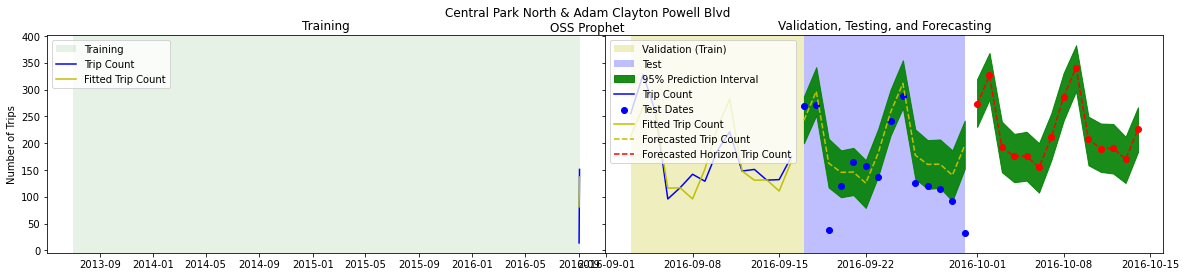

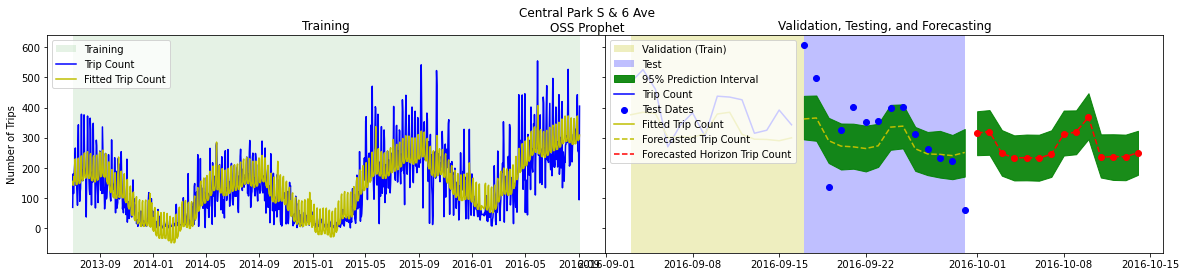

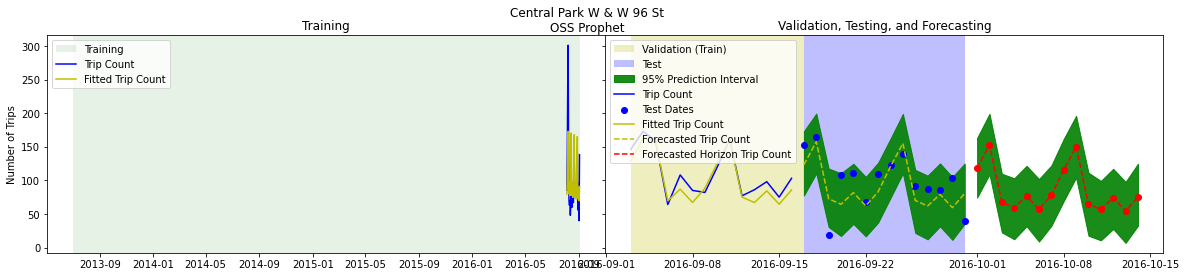

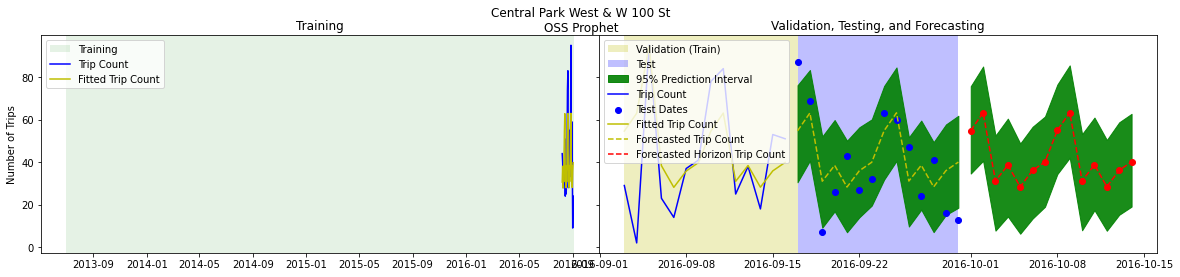

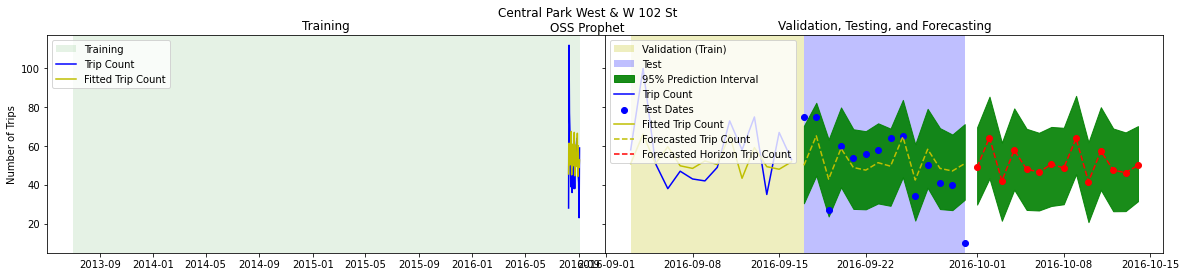

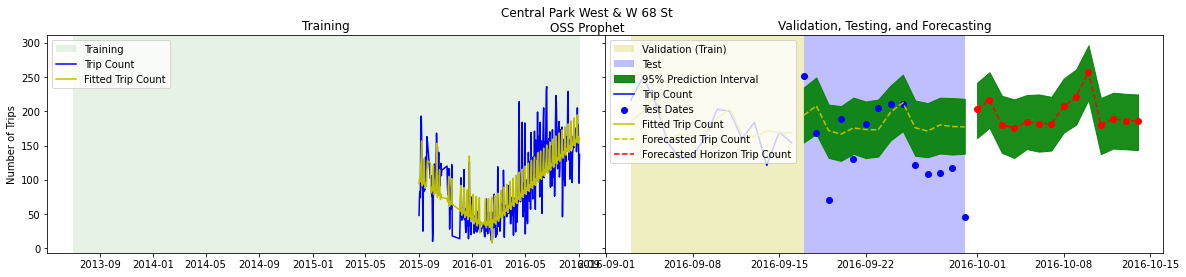

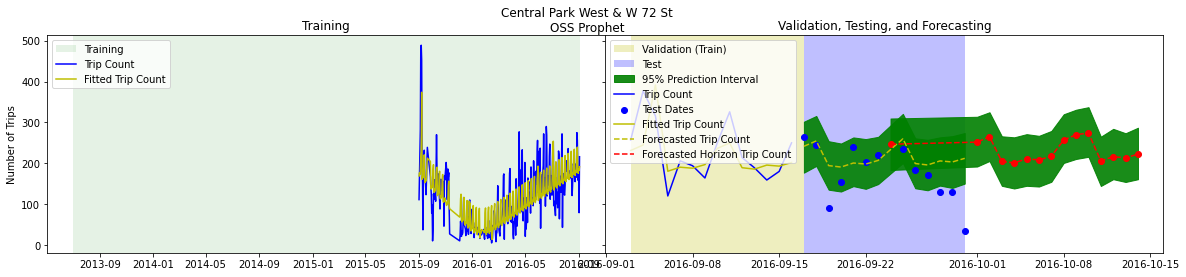

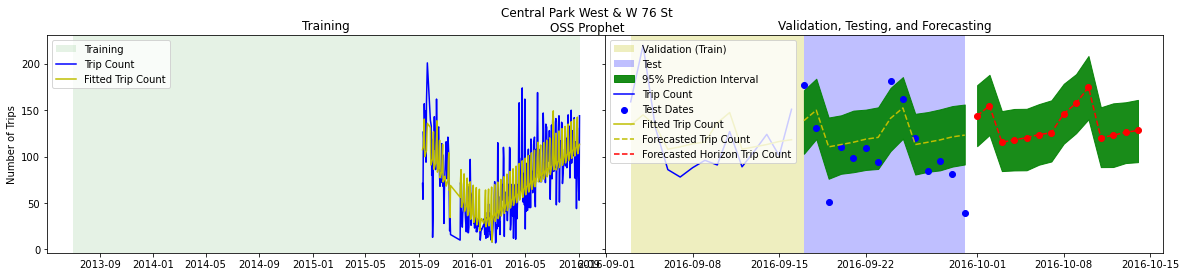

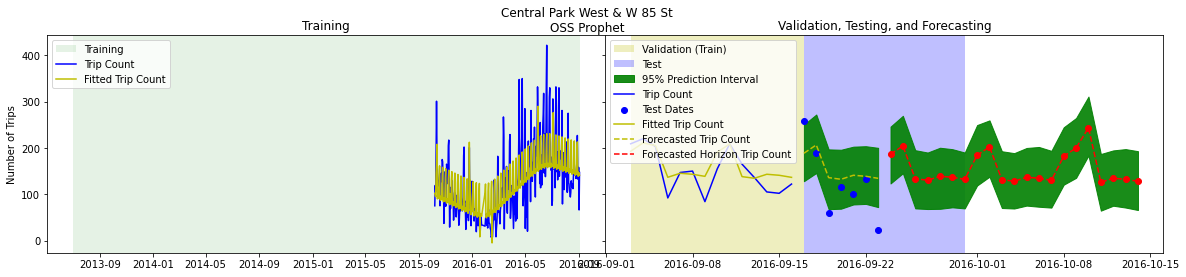

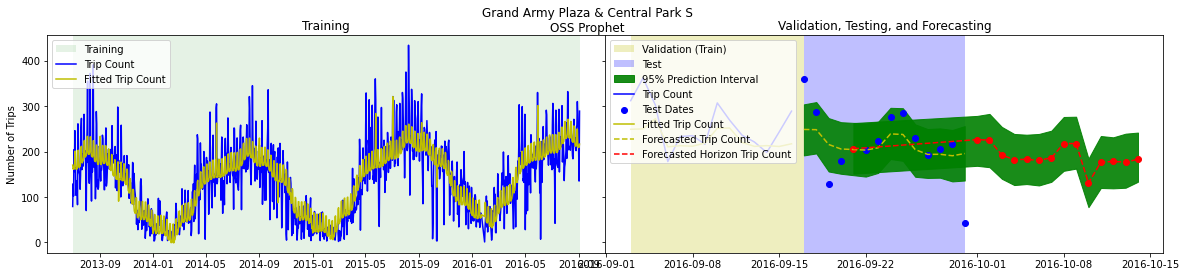

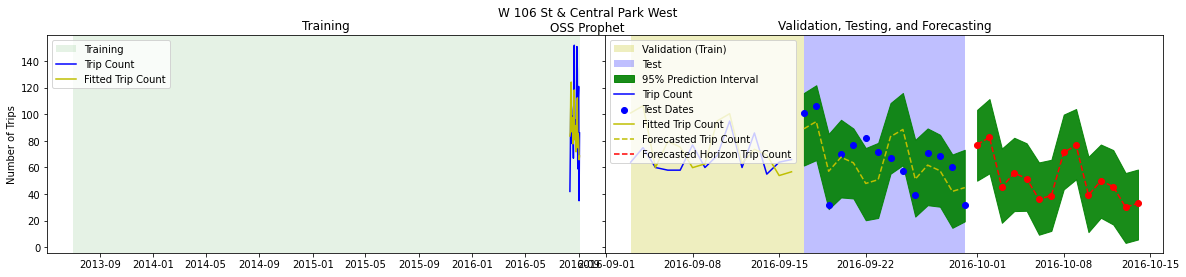

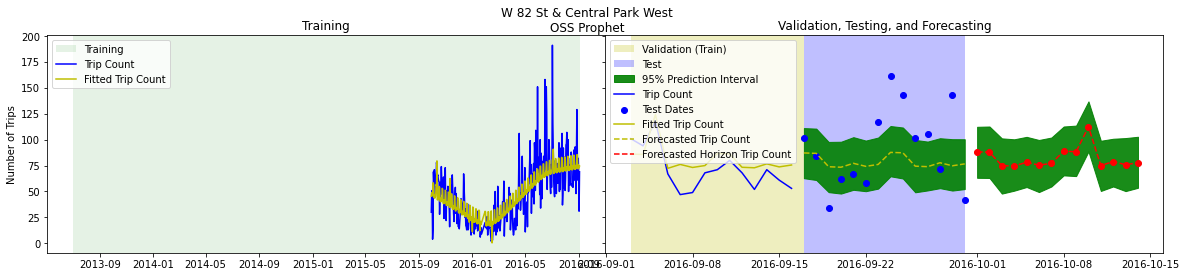

In [117]:
stations = prophet['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TRAIN')]
    valdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'VALIDATE')]
    testdf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'] == 'TEST')]
    horizondf = prophet[(prophet['start_station_name'] == st) & (prophet['splits'].isna())]
    #fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    axes[1].fill_between(testdf['date'], testdf['yhat_lower'], testdf['yhat_upper'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')
    axes[1].fill_between(horizondf['date'], horizondf['yhat_lower'], horizondf['yhat_upper'], color = 'g', alpha = 0.9)
    
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    axes[1].scatter(horizondf['date'], horizondf['yhat'], color = 'r')
    
    axes[0].plot(traindf['date'], traindf['yhat'], color = 'y', label = 'Fitted Trip Count', linestyle='solid')
    axes[1].plot(valdf['date'], valdf['yhat'], color = 'y', label = 'Fitted Trip Count', linestyle='solid')
    axes[1].plot(testdf['date'], testdf['yhat'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].plot(horizondf['date'], horizondf['yhat'], color = 'r', label = 'Forecasted Horizon Trip Count', linestyle='dashed')
    #axes[1].scatter(testdf['date'], testdf['yhat'], color = 'y')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation, Testing, and Forecasting')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nOSS Prophet")

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"